In [2]:
from experiments.Scheduling.eval import strategy, SystemProfile
import matplotlib.pyplot as plt
import numpy as np

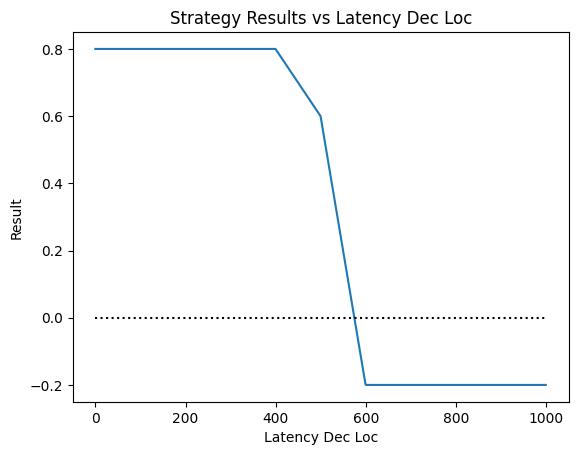

In [6]:
profile = SystemProfile(
    rtt=1,
    latency_dec_rem=5,
    latency_dec_loc=3,
    acceptance_rate_rem=0.2,
    acceptance_rate_loc=0.8
)
y = []
for latency_dec_loc in np.linspace(0, 10, 1000):    
    profile.latency_dec_loc = latency_dec_loc
    result = strategy(profile)
    y.append(result)

plt.plot(y)
plt.hlines([0], 0, 1000, color='k', linestyle=':')
plt.xlabel('Latency Dec Loc')
plt.ylabel('Result')
plt.title('Strategy Results vs Latency Dec Loc')
plt.show()

In [3]:
import json

# with open('tmp.json') as f: stats = json.load(f)
# with open('tmp_profile.json', 'r') as f: stats = json.load(f)
with open('profile.json', 'r') as f: stats = json.load(f)
# with open("tmp_decoder_stats.json", 'r') as f: online_stats = json.load(f)[0]
with open("decoder_stats.json", 'r') as f: online_stats = json.load(f)[0]
latency_dec_loc = np.array([stat["latency_dec_loc"] for stat in stats[:-1]]).T
latency_dec_rem = np.array([stat["latency_dec_rem"] for stat in stats[:-1]]).T
start_step = stats[-1]['start_step'][0]

In [4]:

def denoise(raw_data, window_size=4, threshold=1.0):
    data = []
    for i in range(0, raw_data.shape[0], window_size):
        segment = raw_data[i: i +  window_size]
        mean, std = np.mean(segment), np.std(segment)
        for j, values in enumerate(segment):
            for value in values:
                if abs(value - mean) < std * threshold:
                    data.append([start_step + i + j, value])
    data = np.array(data).T
    return data

def fit_linear_kb(data):
    xs = np.stack([data[0], np.ones_like(data[0])], axis=1)
    k, b = np.linalg.inv(xs.T @ xs) @ xs.T @ np.array(data[1])
    return k, b

def fit_linear_k(data):
    k = (data[0] @ data[1]) / (data[0] @ data[0])
    return k

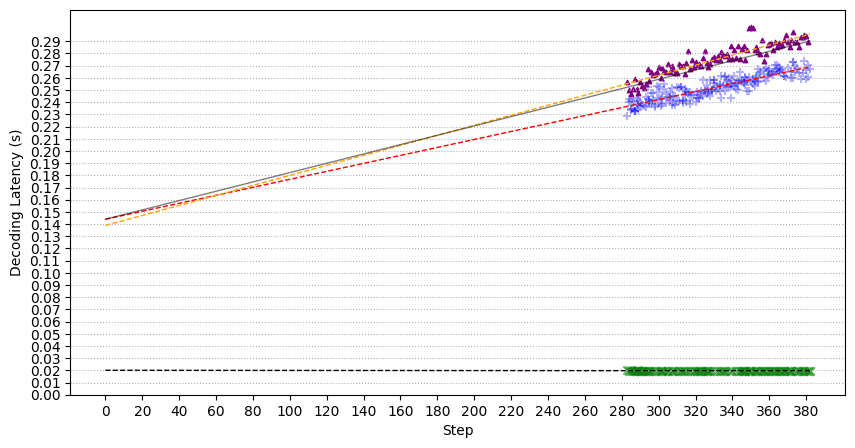

In [22]:
latency_dec_loc_data = denoise(latency_dec_loc, threshold=0.9, window_size=10)
latency_dec_rem_data = denoise(latency_dec_rem, threshold=0.9, window_size=10)

k_loc, b_loc = fit_linear_kb(latency_dec_loc_data)
k_rem, b_rem = fit_linear_kb(latency_dec_rem_data)

# k_loc_ = fit_linear_k(latency_dec_loc_data)
# k_rem_ = fit_linear_k(latency_dec_rem_data)

x_axis = np.arange(start_step + len(stats[0]['latency_dec_loc']))

plt.figure(figsize=(10, 5))
plt.scatter(latency_dec_loc_data[0], latency_dec_loc_data[1], color='b', label='Local', marker='+', alpha=0.3)
plt.scatter(latency_dec_rem_data[0], latency_dec_rem_data[1], color='g', label='Remote', marker='x', alpha=0.3)
plt.plot(x_axis, k_loc * x_axis + b_loc, label='Local Prediction', color='r', linestyle='--', lw=1)
plt.plot(x_axis, k_rem * x_axis + b_rem, label='Remote Prediction', color='k', linestyle='--', lw=1)
# plt.plot(x_axis, k_loc_ * latency_dec_loc_data[0], label='Local Prediction', color='orange')
# plt.plot(x_axis, k_rem_ * latency_dec_rem_data[0], label='Remote Prediction', color='orange')
plt.scatter(
    np.array(online_stats['steps']) + start_step, online_stats['latency_dec_loc'], 
    color='purple', label='Online Local Stats', marker='^', s=10)
k_new, b_new = fit_linear_kb((np.array(online_stats['steps']) + start_step + 1, online_stats['latency_dec_loc']))
plt.plot(x_axis, k_new * x_axis + b_new, label='Online Local Prediction', color='orange', linestyle='--', lw=1)

origin_c = (latency_dec_loc_data[1] - b_loc) @ latency_dec_loc_data[0]
origin_d = latency_dec_loc_data[0] @ latency_dec_loc_data[0]
for t, lat_new in zip(online_stats['steps'], online_stats['latency_dec_loc']):
    origin_c = 0.1 * origin_c + 0.9 * (lat_new - b_loc) * (t + start_step)
    origin_d = 0.1 * origin_d + 0.9 * (t + start_step) * (t + start_step)
    new_k = origin_c / origin_d
    if t == 98:
        plt.plot(x_axis, new_k * x_axis + b_loc, label='New Prediction', color='k', lw=1, alpha=0.5)

plt.grid(axis='y', linestyle=':')
plt.xticks(x_axis[::20])
plt.yticks(np.arange(0, 0.3, 0.01))
plt.xlabel('Step')
plt.ylabel('Decoding Latency (s)')
# plt.legend()
plt.show()